In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score

import warnings
warnings.filterwarnings("ignore")

# Classification

### Slight Cleaning 

- Set all string variables to have uniformly lower case letters
- Try out setting latitude longitude to numeric
- Drop missing lat/long

In [37]:
data = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv')

for col in data.columns:
    if data[col].dtype == 'object': 
        data[col] = data[col].str.lower()


data = data[~(data['damage']=='UNK')]


In [38]:
data['damage'].value_counts(normalize=True)

damage
subs    0.897798
dest    0.085204
unk     0.009942
minr    0.007056
Name: proportion, dtype: float64

### Note on class imbalance:
- Almost 90% of our accidents are "substantial."  I think that, given this massive imbalance, we may have to switch the target variable to the second-highest category, which is destroyed, to capture some level of variation.  
- However, it is worth trying some preliminary anlayses to see how different learners (I exclude some others have used in different notebooks)

In [39]:
features = ['latitude','longitude','apt_dist','gust_kts','altimeter','aircraft_count',
            'num_eng','days_since_insp','light_cond_DAYL','light_cond_DUSK','light_cond_NDRK',
            'light_cond_NITE','light_cond_other/unknown','BroadPhaseofFlight_Air',
            'BroadPhaseofFlight_Ground','BroadPhaseofFlight_Landing','BroadPhaseofFlight_Takeoff',
            'BroadPhaseofFlight_other/unknown','eng_type_REC','eng_type_TF','eng_type_TP','eng_type_TS',
            'eng_type_other/unknown','far_part_091','far_part_121','far_part_135','far_part_137','far_part_PUBU',
            'far_part_other/unknown','acft_make_beech','acft_make_bell','acft_make_boeing','acft_make_cessna',
            'acft_make_mooney','acft_make_other/unknown','acft_make_piper','acft_make_robinson helicopter',
            'acft_category_AIR','acft_category_HELI','acft_category_other/unknown','homebuilt_N','homebuilt_Y',
            'fixed_retractable_FIXD','fixed_retractable_RETR',
            'second_pilot_N','second_pilot_Y','second_pilot_other/unknown']

target = ['damage']

X = data[features]
y = data[target]

### Train test split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=2025)

In [41]:
X_train.shape

(6547, 47)

### Grid search: Histogram Gradient Boost & Extra Trees Classifiers

In [43]:
histgrad = HistGradientBoostingClassifier()

# GridSearch 
param_grid = {
    'learning_rate': [0.01],
    'max_iter': [100],
    'max_leaf_nodes': [3,6]
}

grid = GridSearchCV(
    histgrad,
    param_grid,
    scoring='f1_macro',
    cv=3,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01], 'max_iter': [100],
                         'max_leaf_nodes': [3, 6]},
             scoring='f1_macro')

In [44]:
grid.best_estimator_

HistGradientBoostingClassifier(learning_rate=0.01, max_leaf_nodes=6)

In [45]:
grid.best_params_

{'learning_rate': 0.01, 'max_iter': 100, 'max_leaf_nodes': 6}

In [46]:
grid.best_score_

np.float64(0.3369536313140223)

### Extra Trees

In [47]:
extrees = ExtraTreesClassifier()

# GridSearch 
param_grid = {
    'max_depth': [2,10],
    'n_estimators': [10],
    'max_leaf_nodes': [3]
}

grid = GridSearchCV(
    extrees,
    param_grid,
    scoring='f1_macro',
    cv=3,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [2, 10], 'max_leaf_nodes': [3],
                         'n_estimators': [10]},
             scoring='f1_macro')

In [48]:
grid.best_estimator_

ExtraTreesClassifier(max_depth=2, max_leaf_nodes=3, n_estimators=10)

In [49]:
grid.best_params_

{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 10}

In [50]:
grid.best_score_

np.float64(0.23647560709156665)

# Testing "Destroyed" Binary Classification Learner
- Re-creates the dataset, but the target becomes a binary "was the aircraft destroyed" indicator (900/~10000 observations)
- See if switch from multiclass to binary target leads to increase in performance
  

In [52]:
data = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv')

for col in data.columns:
    if data[col].dtype == 'object': 
        data[col] = data[col].str.lower()


data = data[~(data['damage']=='UNK')]


damage = pd.get_dummies(data['damage'],dtype='int') # Dummy out target 
data['destroyed'] = damage['dest'] # Create binary classifier

In [54]:
features = ['latitude','longitude','apt_dist','gust_kts','altimeter','aircraft_count',
            'num_eng','days_since_insp','light_cond_DAYL','light_cond_DUSK','light_cond_NDRK',
            'light_cond_NITE','light_cond_other/unknown','BroadPhaseofFlight_Air',
            'BroadPhaseofFlight_Ground','BroadPhaseofFlight_Landing','BroadPhaseofFlight_Takeoff',
            'BroadPhaseofFlight_other/unknown','eng_type_REC','eng_type_TF','eng_type_TP','eng_type_TS',
            'eng_type_other/unknown','far_part_091','far_part_121','far_part_135','far_part_137','far_part_PUBU',
            'far_part_other/unknown','acft_make_beech','acft_make_bell','acft_make_boeing','acft_make_cessna',
            'acft_make_mooney','acft_make_other/unknown','acft_make_piper','acft_make_robinson helicopter',
            'acft_category_AIR','acft_category_HELI','acft_category_other/unknown','homebuilt_N','homebuilt_Y',
            'fixed_retractable_FIXD','fixed_retractable_RETR',
            'second_pilot_N','second_pilot_Y','second_pilot_other/unknown']

target = ['destroyed']
X = data[features]
y = data[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=2025)

In [55]:
y.value_counts()

destroyed
0            8557
1             797
Name: count, dtype: int64

In [56]:
#data.columns

In [57]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty=None)

## fit the model
log_reg.fit(X_train,y_train)


LogisticRegression(penalty=None)

In [58]:
# Calculate accuracy on the test set
test_accuracy = log_reg.score(X_val, y_val)
print(f"Test Accuracy (model.score()): {test_accuracy:.4f}")

# Alternatively, predict and use accuracy_score
y_pred = log_reg.predict(X_val)
accuracy_from_metric = accuracy_score(y_val, y_pred)
print(f"Test Accuracy (accuracy_score): {accuracy_from_metric:.4f}")

Test Accuracy (model.score()): 0.9156
Test Accuracy (accuracy_score): 0.9156


In [59]:
confusion_matrix(y_pred,y_val)

array([[2568,  237],
       [   0,    2]])

In [61]:
histgrad = HistGradientBoostingClassifier()

# GridSearch 
param_grid = {
    'learning_rate': [0.01],
    'max_iter': [100],
    'max_leaf_nodes': [3,6]
}

grid = GridSearchCV(
    histgrad,
    param_grid,
    scoring='f1_macro',
    cv=3,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01], 'max_iter': [100],
                         'max_leaf_nodes': [3, 6]},
             scoring='f1_macro')

In [62]:
model = grid.best_estimator_
model

HistGradientBoostingClassifier(learning_rate=0.01, max_leaf_nodes=3)

In [63]:
grid.best_score_

np.float64(0.4777440958678519)

In [64]:
probs = pd.DataFrame(model.predict_proba(X_val))

In [65]:
probs

,0,1
0,0.947151,0.052849
1,0.939538,0.060462
2,0.923708,0.076292
3,0.923708,0.076292
4,0.947151,0.052849
...,...,...
2802,0.877076,0.122924
2803,0.933800,0.066200
2804,0.867749,0.132251
2805,0.913028,0.086972


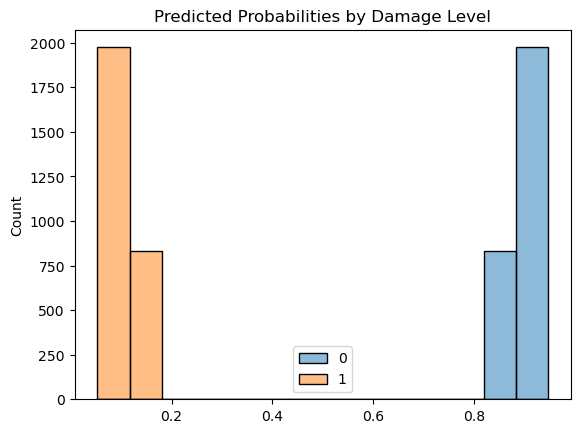

In [66]:
sns.histplot(probs)
plt.title("Predicted Probabilities by Damage Level")
plt.show()

In [67]:
len(probs[probs[1] > 0.50]) / len(y_train)

0.0

In [68]:
y.mean()

destroyed    0.085204
dtype: float64

<Axes: >

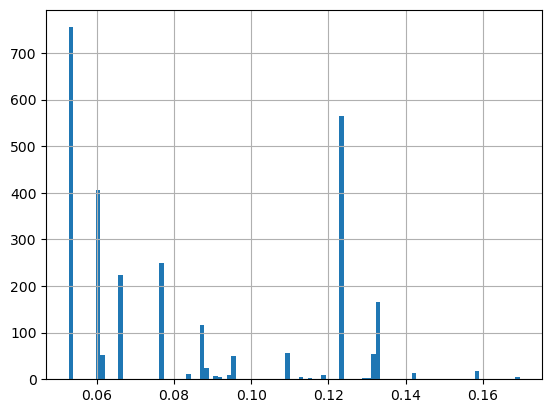

In [69]:
probs[1].hist(bins=100)

#### Note:
This plot of the predicted probabilities of the "destroyed" binary measure shows that we have very few observations whose probability of being "destroyed" is greater than 0.5 - only 1.4% of the training data have a probability of being destroyed despite 8% actually being destroyed.  I am unsure as to how to best proceed.

### Extra Trees Binary Classifier

In [71]:
extrees = ExtraTreesClassifier()

# GridSearch 
param_grid = {
    'max_depth': [2],
    'n_estimators': [10],
    'max_leaf_nodes': [3]
}

grid = GridSearchCV(
    extrees,
    param_grid,
    scoring='f1_macro',
    cv=3,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [2], 'max_leaf_nodes': [3],
                         'n_estimators': [10]},
             scoring='f1_macro')

In [72]:
grid.best_score_

np.float64(0.4777440958678519)

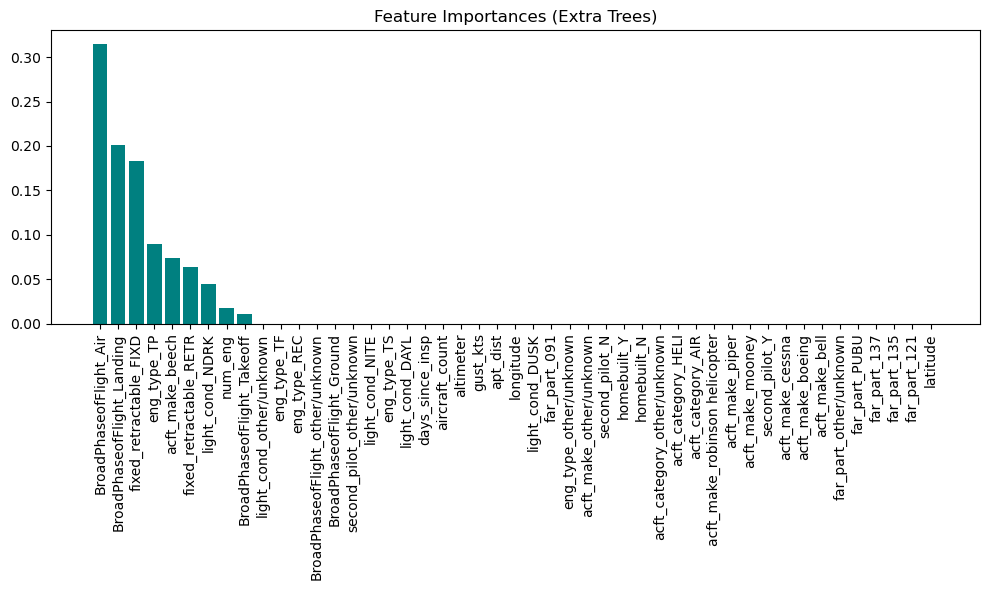

In [73]:
model = grid.best_estimator_
importances = model.feature_importances_
feats = X_train.columns


indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Extra Trees)")
plt.bar(range(len(feats)), importances[indices], color="teal", align="center")
plt.xticks(range(len(feats)), [feats[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

### Testing a Dumb Learner
- Out of interest, I am going to create a learner which only predicts non-destroyed planes and see how its performance compares to our "smarter" learners.

In [74]:
y_dumb = np.zeros(len(y_train))
f1_score(y_dumb,y_train,average='macro')

0.47774409700063813

In [75]:
y_dumb = np.zeros(len(y_val))
f1_score(y_dumb,y_val,average='macro')

0.4777674418604651

Sadly, our "dumb" learner performs basically as well as our other learner...

# Regression with Proportion of Serious/Fatal as Target

In [83]:
data = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv').dropna()

for col in data.columns:
    if data[col].dtype == 'object': 
        data[col] = data[col].str.lower()


data = data[~(data['damage']=='UNK')]


data['destroyed'] = damage['dest'] # Create binary classifier

In [84]:
data['prop_sf'] = data['acft_prop_inj_f'] + data['acft_prop_inj_s']

prop_sf
0.000000    5173
1.000000    1628
0.500000     176
0.333333      31
0.250000      24
0.666667      20
0.200000       7
0.750000       5
0.166667       5
0.800000       3
0.400000       2
0.857143       2
0.007042       2
0.083333       2
0.600000       1
1.000000       1
0.016393       1
0.008333       1
0.005348       1
0.006944       1
0.428571       1
0.006410       1
0.008264       1
0.015152       1
0.625000       1
0.090909       1
0.066667       1
0.076923       1
0.833333       1
0.545455       1
0.010753       1
0.009259       1
0.007812       1
0.015385       1
0.011628       1
0.005263       1
0.024691       1
0.030303       1
0.045455       1
0.018868       1
0.100000       1
0.111111       1
0.571429       1
0.007299       1
0.013072       1
0.011905       1
0.142857       1
0.008197       1
0.007143       1
0.011765       1
0.008547       1
0.033333       1
0.044444       1
0.034483       1
0.900000       1
0.011236       1
0.600000       1
0.006579       1
0.0038

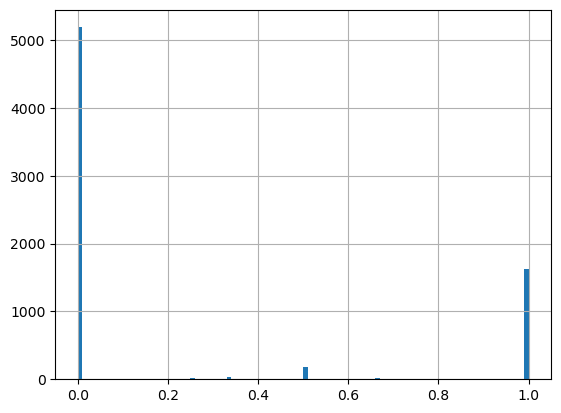

In [85]:
data['prop_sf'].hist(bins=100)
data.prop_sf.value_counts()

In [86]:
target = ['prop_sf']
X = data[features]
y = data[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=2025)

#### Note:
Again, we have pretty extreme imbalance in the variable - most are not injured seriously or more, while others are 100% serious or more, with little population between the two.  

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [89]:
rf = RandomForestRegressor()

# GridSearch 
param_grid = {
    'n_estimators':[10],
    'min_samples_leaf':[2],
    'max_samples':[100]
}

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1_macro',
    cv=3,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_samples': [100], 'min_samples_leaf': [2],
                         'n_estimators': [10]},
             scoring='f1_macro')

In [90]:
model = grid.best_estimator_
model

RandomForestRegressor(max_samples=100, min_samples_leaf=2, n_estimators=10)

Train set score

In [91]:
y_pred =model.predict(X_train)
print(f'MSE: {mean_squared_error(y_pred,y_train)}')
print(f'MAE: {mean_absolute_error(y_pred,y_train)}')

MSE: 0.16420358986895958
MAE: 0.3310357361929265


Validation set score

In [92]:
y_pred =model.predict(X_val)

In [93]:
print(f'MSE: {mean_squared_error(y_pred,y_val)}')
print(f'MAE: {mean_absolute_error(y_pred,y_val)}')

MSE: 0.16261657503216895
MAE: 0.32776118979834823


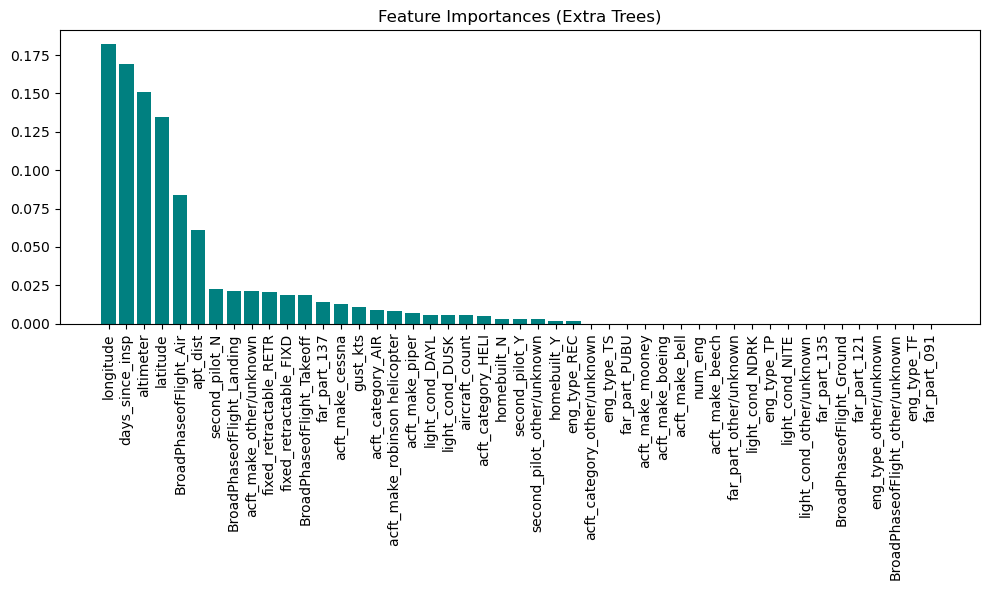

In [94]:
importances = model.feature_importances_
feats = X_train.columns


indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Extra Trees)")
plt.bar(range(len(feats)), importances[indices], color="teal", align="center")
plt.xticks(range(len(feats)), [feats[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## Histogram Gradient Boosting Regressor

In [95]:
histgrad = HistGradientBoostingRegressor()

# GridSearch 
param_grid = {
    'learning_rate': [0.01,0.05,0.1,0.5,1],
    'max_iter': [100,200,500],
    'max_leaf_nodes': [3,6]
}

grid = GridSearchCV(
    histgrad,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'max_iter': [100, 200, 500],
                         'max_leaf_nodes': [3, 6]},
             scoring='f1_macro')

In [96]:

model = grid.best_estimator_

In [97]:
y_pred =model.predict(X_train)
print(f'MSE: {mean_squared_error(y_pred,y_train)}')
print(f'MAE: {mean_absolute_error(y_pred,y_train)}')

MSE: 0.1630878853130349
MAE: 0.34487690459667275


In [98]:
y_pred =model.predict(X_val)
print(f'MSE: {mean_squared_error(y_pred,y_val)}')
print(f'MAE: {mean_absolute_error(y_pred,y_val)}')

MSE: 0.15233314860880925
MAE: 0.3324559310750837


In [99]:
grid.best_params_

{'learning_rate': 0.01, 'max_iter': 100, 'max_leaf_nodes': 3}

# Fatal Injury Proportion Only

In [100]:
target = ['acft_prop_inj_f']
X = data[features]
y = data[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=2025)

## Random Forest Regressor

In [101]:
rf = RandomForestRegressor()

# GridSearch 
param_grid = {
    'n_estimators':[10,500,1000],
    'min_samples_leaf':[2,5,10, 20],
    'max_samples':[100,500,1000]
}

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_

In [102]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')

{'max_samples': 100, 'min_samples_leaf': 2, 'n_estimators': 10}
Training MSE: 0.11812856242917588
Training MAE: 0.2416149954695172
Validation MSE: 0.10603556092900439
Validation MAE: 0.22608227301749284


## Histogram Gradient Boosting Regressor

In [103]:
histgrad = HistGradientBoostingRegressor()

# GridSearch 
param_grid = {
    'learning_rate': [0.01,0.05,0.1,0.5,1],
    'max_iter': [100,200,500],
    'max_leaf_nodes': [3,6,9]
}

grid = GridSearchCV(
    histgrad,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_


In [104]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')

{'learning_rate': 0.01, 'max_iter': 100, 'max_leaf_nodes': 3}
Training MSE: 0.12031726261579004
Training MAE: 0.2543150411934839
Validation MSE: 0.10460974675551243
Validation MAE: 0.23722052320948725


## Extra Trees Regressor

In [105]:
extrees = ExtraTreesRegressor()

# GridSearch 
param_grid = {
    'max_depth': [2,10,50,100,1000],
    'n_estimators': [10,100,500,1000],
    'max_leaf_nodes': [3,6,36,90]
}

grid = GridSearchCV(
    extrees,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_

In [106]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')


{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 10}
Training MSE: 0.12167858740525907
Training MAE: 0.250128741788953
Validation MSE: 0.10561861284453392
Validation MAE: 0.2328866415539757


## Bagging Regressor

In [107]:
baggingreg = BaggingRegressor()

# GridSearch 
param_grid = {
    'n_estimators': [10,100,500,1000],
}

grid = GridSearchCV(
    baggingreg,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_

In [108]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')

{'n_estimators': 10}
Training MSE: 0.022549312717212514
Training MAE: 0.08559958155606842
Validation MSE: 0.11048732307444431
Validation MAE: 0.2111403119798817


In [109]:
importances = np.mean(
    [tree.feature_importances_ for tree in model.estimators_],
    axis=0
)

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                             Feature  Importance
7                    days_since_insp    0.167159
1                          longitude    0.161451
0                           latitude    0.150870
4                          altimeter    0.125792
2                           apt_dist    0.066650
13            BroadPhaseofFlight_Air    0.064606
3                           gust_kts    0.030822
32                  acft_make_cessna    0.015240
43            fixed_retractable_RETR    0.014097
8                    light_cond_DAYL    0.013962
35                   acft_make_piper    0.012628
16        BroadPhaseofFlight_Takeoff    0.011687
42            fixed_retractable_FIXD    0.011423
34           acft_make_other/unknown    0.010285
44                    second_pilot_N    0.009642
45                    second_pilot_Y    0.009390
10                   light_cond_NDRK    0.008849
6                            num_eng    0.008207
29                   acft_make_beech    0.007687
18                  

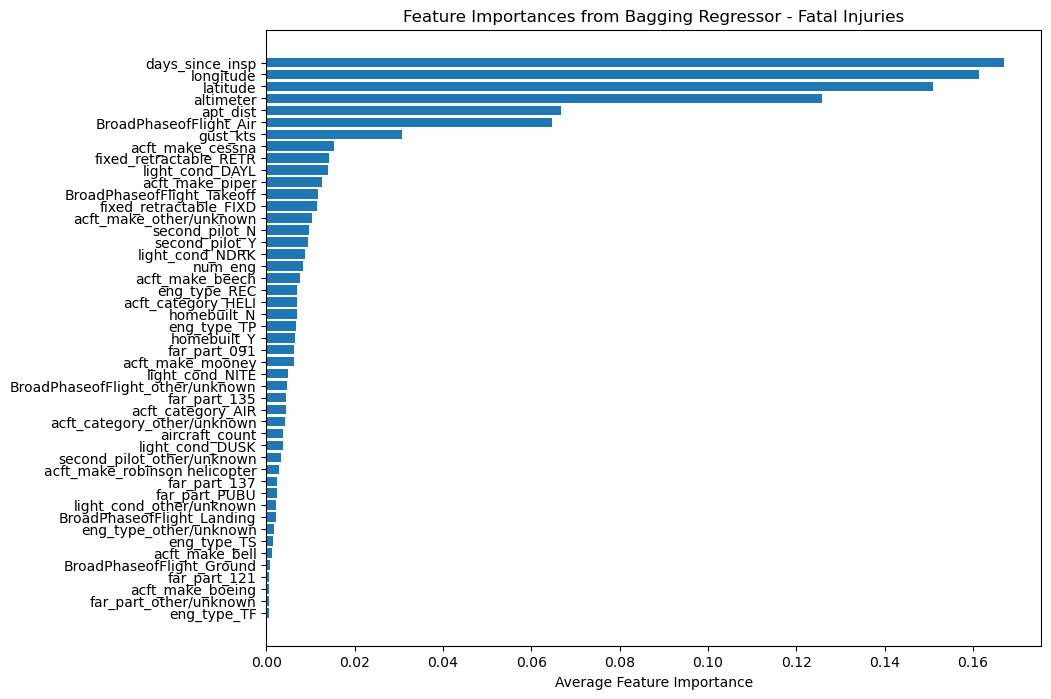

In [110]:
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Average Feature Importance")
plt.title("Feature Importances from Bagging Regressor - Fatal Injuries")
plt.show()

# Serious Injury Proportion

In [111]:
target = ['acft_prop_inj_s']
X = data[features]
y = data[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=2025)

## Random Forest

In [112]:
rf = RandomForestRegressor()

# GridSearch 
param_grid = {
    'n_estimators':[10,500,1000],
    'min_samples_leaf':[2,5,10, 20],
    'max_samples':[100,500,1000]
}

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_

In [113]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')

{'max_samples': 100, 'min_samples_leaf': 2, 'n_estimators': 10}
Training MSE: 0.07446365748595926
Training MAE: 0.16826007434262483
Validation MSE: 0.07941081781428384
Validation MAE: 0.17551688460909182


## Hist Gradient Regressor

In [114]:
histgrad = HistGradientBoostingRegressor()

# GridSearch 
param_grid = {
    'learning_rate': [0.01,0.05,0.1,0.5,1],
    'max_iter': [100,200,500],
    'max_leaf_nodes': [3,6,9]
}

grid = GridSearchCV(
    histgrad,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_

In [115]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')

{'learning_rate': 0.01, 'max_iter': 100, 'max_leaf_nodes': 3}
Training MSE: 0.06804919210004903
Training MAE: 0.15631172668342752
Validation MSE: 0.07130907041901739
Validation MAE: 0.15874627297074598


## Extra Trees

In [116]:
extrees = ExtraTreesRegressor()

# GridSearch 
param_grid = {
    'max_depth': [2,10,50,100,1000],
    'n_estimators': [10,100,500,1000],
    'max_leaf_nodes': [3,6,36,90]
}

grid = GridSearchCV(
    extrees,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_

In [117]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')

{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 10}
Training MSE: 0.06817284879050071
Training MAE: 0.1553523326733113
Validation MSE: 0.07121848672076887
Validation MAE: 0.15693438875255722


## Bagging Regressor

In [118]:
baggingreg = BaggingRegressor()

# GridSearch 
param_grid = {
    'n_estimators': [10,100,500,1000],
}

grid = GridSearchCV(
    baggingreg,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

model = grid.best_estimator_

In [119]:
y_pred =model.predict(X_train)
y_pred2 =model.predict(X_val)
print(grid.best_params_)
print(f'Training MSE: {mean_squared_error(y_pred,y_train)}')
print(f'Training MAE: {mean_absolute_error(y_pred,y_train)}')
print(f'Validation MSE: {mean_squared_error(y_pred2,y_val)}')
print(f'Validation MAE: {mean_absolute_error(y_pred2,y_val)}')

{'n_estimators': 10}
Training MSE: 0.014277674900534106
Training MAE: 0.06141293418588023
Validation MSE: 0.08384913510803337
Validation MAE: 0.17057566878413397


In [120]:
importances = np.mean(
    [tree.feature_importances_ for tree in model.estimators_],
    axis=0
)

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                             Feature  Importance
1                          longitude    0.193780
7                    days_since_insp    0.180470
0                           latitude    0.179669
4                          altimeter    0.133520
3                           gust_kts    0.041119
2                           apt_dist    0.034774
34           acft_make_other/unknown    0.013166
15        BroadPhaseofFlight_Landing    0.012738
35                   acft_make_piper    0.012591
45                    second_pilot_Y    0.010872
40                       homebuilt_N    0.010554
6                            num_eng    0.009358
29                   acft_make_beech    0.008955
32                  acft_make_cessna    0.008955
41                       homebuilt_Y    0.008691
44                    second_pilot_N    0.008123
42            fixed_retractable_FIXD    0.007672
13            BroadPhaseofFlight_Air    0.007585
26                      far_part_137    0.007422
43            fixed_

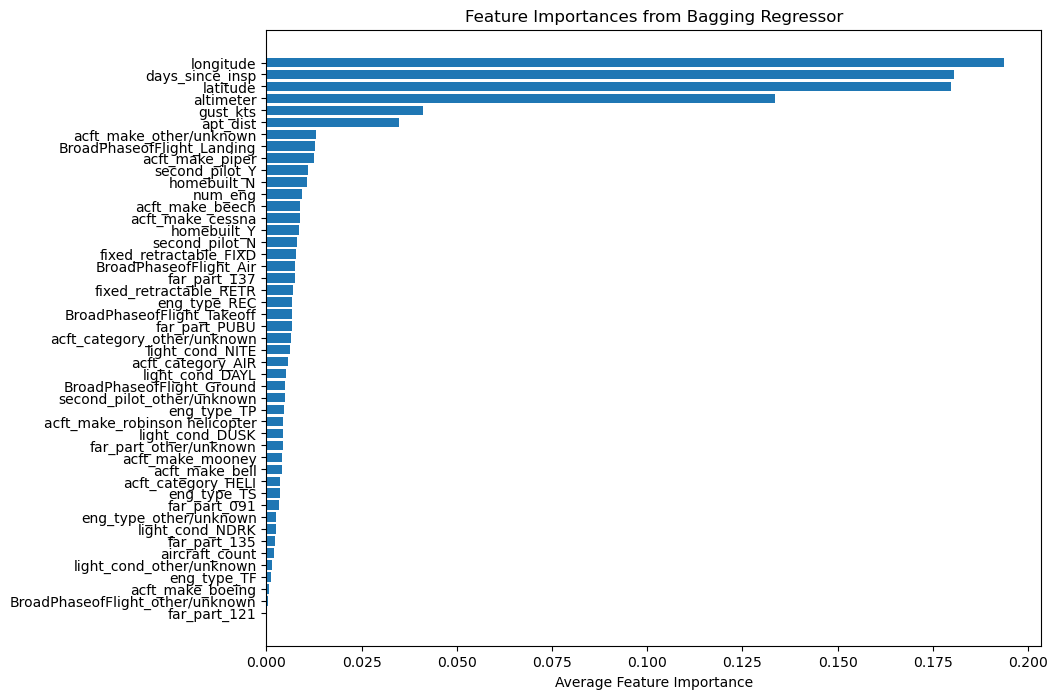

In [121]:
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Average Feature Importance")
plt.title("Feature Importances from Bagging Regressor")
plt.show()